In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pylab import *
import sys; sys.path.insert(0, "../")
import numpy as np
import time
from matplotlib.animation import FuncAnimation

from pandas import DataFrame
import seaborn as sns

from emcee.autocorr import *
from ensemble_sampler import *

In [111]:
def fake_proposals(p0, walker_to_move=0, N=100):
    curr_walker = p0[None, walker_to_move, :]
    ens_idx = np.delete(np.arange(p0.shape[0]), walker_to_move)
    ensemble = p0[ens_idx]
    curr_lnprob = t_dist.get_lnprob(curr_walker)
    accepted_proposals = []
    unaccepted_proposals = []

    for i in range(N):
        p, blobs = proposal.propose(walkers_to_move=curr_walker, ensemble=ensemble)
        proposal_lnprob = t_dist.get_lnprob(p)
        ln_transition_prob_1 = proposal.ln_transition_prob(p, curr_walker)
        ln_transition_prob_2 = proposal.ln_transition_prob(curr_walker, p)
        ln_acc_prob = (proposal_lnprob + ln_transition_prob_1) - (curr_lnprob + ln_transition_prob_2)
        accept = (np.log(np.random.uniform(size=1)) < ln_acc_prob)
        if accept:
            accepted_proposals.append(p)
        else:
            unaccepted_proposals.append(p)
    accepted_proposals = np.array(accepted_proposals).squeeze()
    unaccepted_proposals = np.array(unaccepted_proposals).squeeze()
    
    return accepted_proposals, unaccepted_proposals

def plot_fake_proposal_2d(proposal, t_dist, p0, walker_to_move=0, N=100, prefix=""):
    nwalkers = p0.shape[0]
    clr = matplotlib.colors.cnames.keys()[:nwalkers]

    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(211, xlim=(-2, 2), ylim=(-2, 2))
    ax2 = fig.add_subplot(212)

    for k in range(nwalkers):
        if k == walker_to_move:
            ax1.scatter(p0[k, 0], p0[k, 1], c=clr[k], s=100, marker='>', label='walker_%s_(moving)' % k)
        else:
            ax1.scatter(p0[k, 0], p0[k, 1], c=clr[k], s=100, label='walker_%s' % k)

    accepted_proposals, unaccepted_proposals = fake_proposals(p0, walker_to_move, N)
    ax2.scatter(accepted_proposals[:, 0], accepted_proposals[:, 1], marker='o', 
                alpha=0.8, label='accepted_proposals')
    ax2.scatter(unaccepted_proposals[:, 0], unaccepted_proposals[:, 1], marker='x', 
                alpha=0.6, label='unaccepted_proposals')

    ax1.legend()
    ax2.legend()

# Exp 1. 2D PCN Walk Move, start at (1, 1), (-1, 1), (1, -1), (-1, -1)

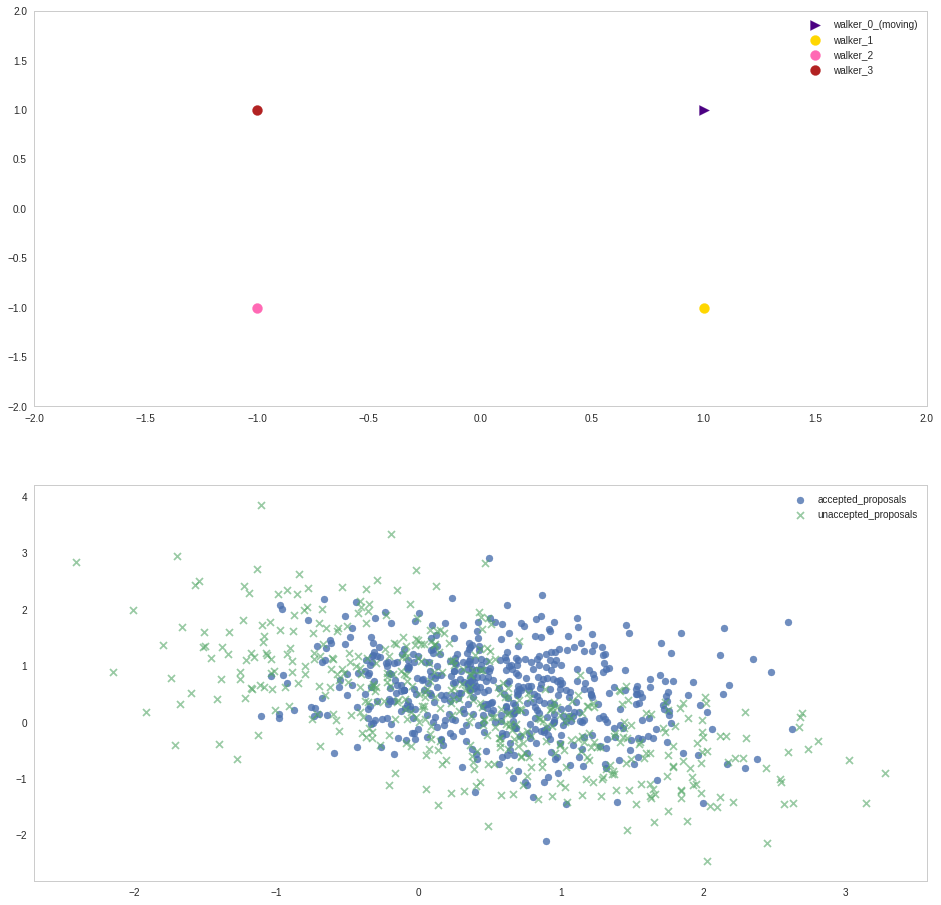

In [91]:
dim = 2
nwalkers = 4

mu = np.zeros(dim)
cov = np.identity(dim)
t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

proposal = PCNWalkMove(beta=0.8)

p0 = np.array([[1.0, 1.0], [1.0, -1.0], [-1.0, -1.0], [-1.0, 1.0]]).reshape([4, 2])

plot_fake_proposal_2d(proposal, t_dist, p0, 0, 1000, prefix="")

In [ ]:
dim = 1
nwalkers = 3

mu = np.zeros(dim)
cov = np.identity(dim)
t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)
proposal = PCNWalkMove(beta=0.8)

p0 = np.array([0.0, 1.0, -1.0]).reshape([nwalkers, dim])

accepted_proposals, unaccepted_proposals = fake_proposals(p0, 0, 100000)

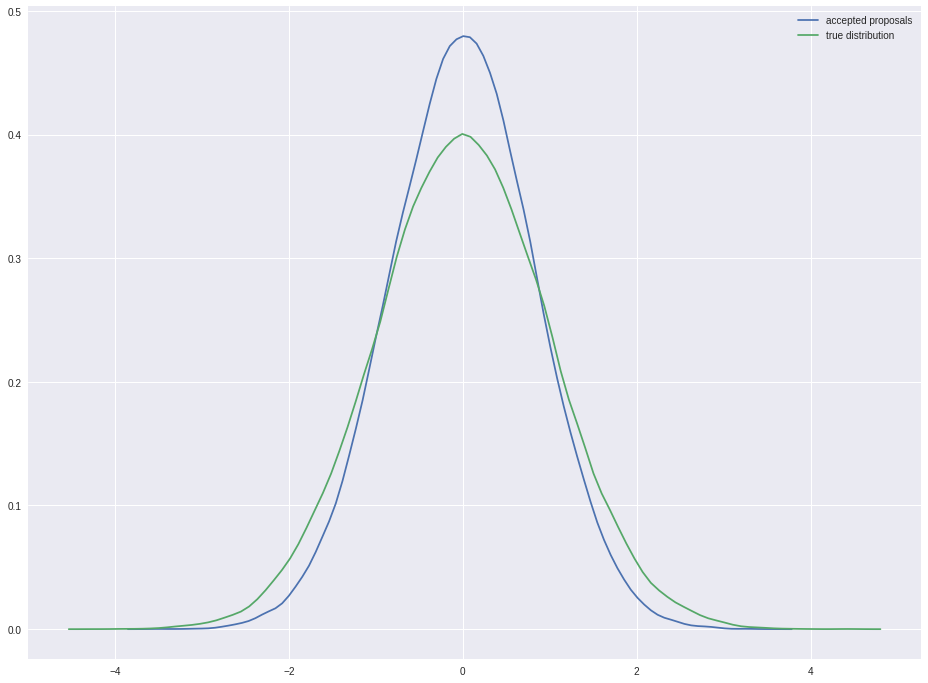

In [142]:
import seaborn as sns
sns.set(rc={"figure.figsize":(16, 12)})
sns.distplot(accepted_proposals, hist=False, kde=True, label='accepted proposals')
# sns.distplot(unaccepted_proposals, hist=False, kde=True, label='unaccepted proposals')
sns.distplot(true_dist, hist=False, kde=True, label='true distribution')
# sns.distplot(proposal_dist, hist=False, kde=True, label='proposal distribution')
# sns.distplot(np.concatenate([accepted_proposals, unaccepted_proposals]), hist=False, kde=True, label='all proposals')
plt.legend()

In [131]:
true_dist = np.zeros(100000)
proposal_dist = np.zeros(100000)
for i in range(100000):
    true_dist[i] = np.random.normal(0, 1)
    proposal_dist[i] = 0.8 * np.random.normal(0, np.sqrt(2))

/home/jialin/.local/lib/python2.7/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in true_divide
  return acf / acf[m]
/home/jialin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


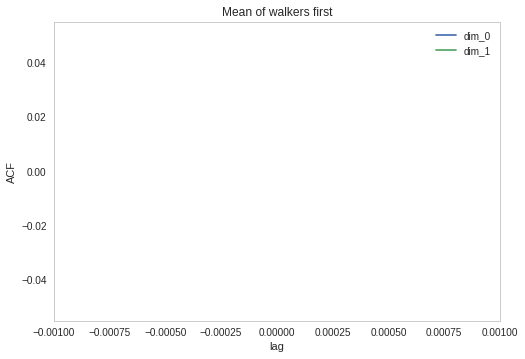

In [63]:
plot_acf(chain, mean_first=True, max_lag=1000)

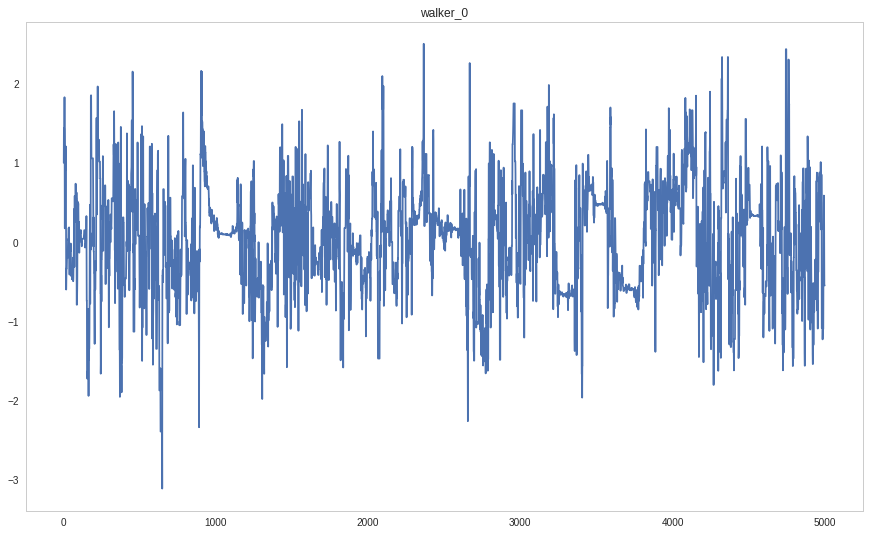

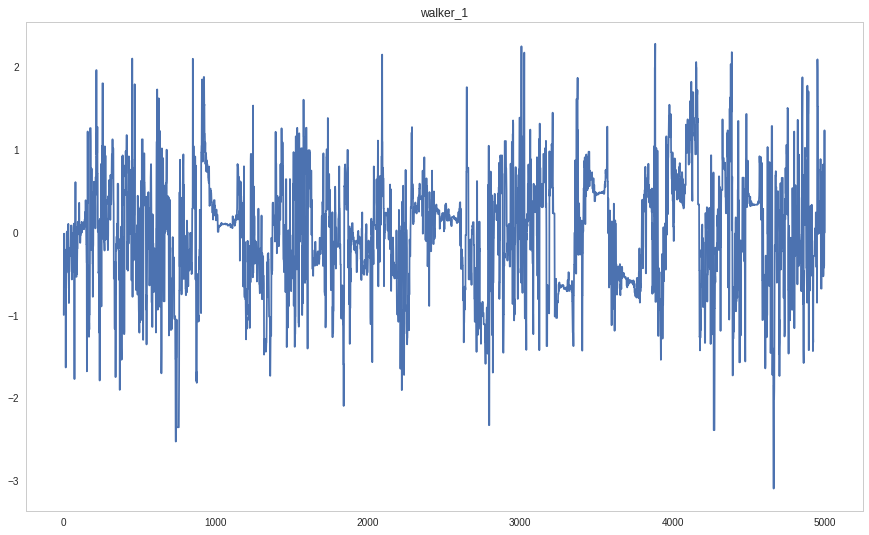

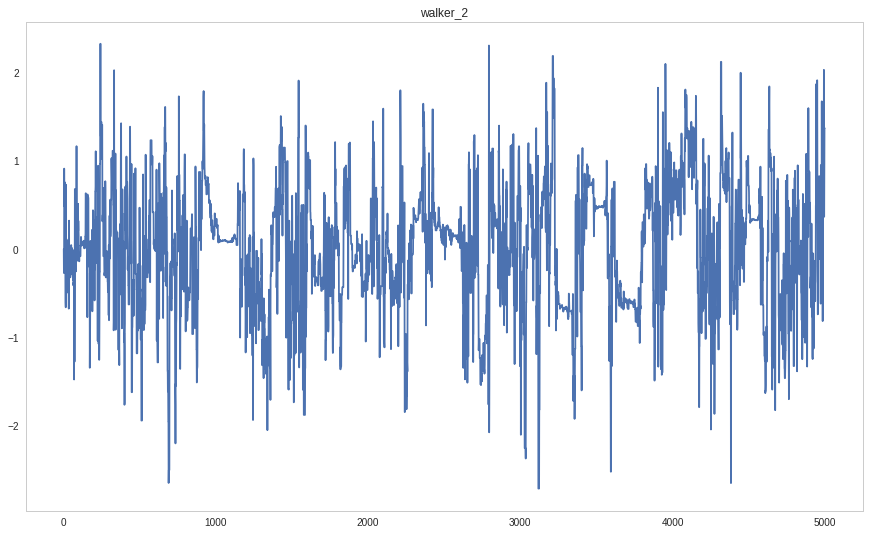

In [11]:
for i in range(nwalkers):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(np.arange(5000), chain[i, :5000, 0])
    plt.title('walker_%s' % i)
plt.show()

# Exp 2. Random Walk Move, start at position@iter_800

In [14]:
proposal = WalkMove(ensemble=True, scale=0.8)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

p0 = chain[:, 1500, :]
try:
    sampler.run_mcmc(niters, batch_size=1, p0=p0, store=True, store_every=50000, title='test')
except LinAlgError, err:
    print err
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

auto-correlation time: [ 26.03503404  17.37561432]


In [15]:
chain = sampler.history.get('chain')
x = sampler.history.get('x')
new_pos = sampler.history.get('new_pos')
accepted = sampler.accepted
start = np.where(chain[0,:,0]==0)[0][0]

 ### TODO:
 1. Animate
 2. Visualize for simple walk move
 3. Use more walkers (10?)

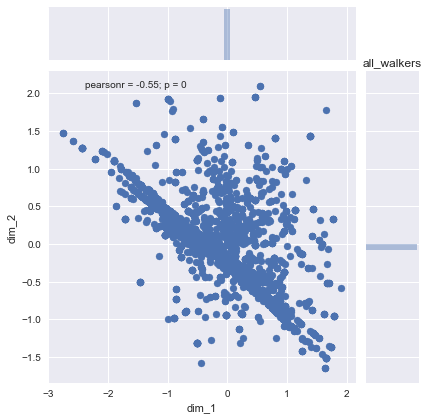

In [60]:
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[:, 0], chain[:, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df)
sns.plt.title('all_walkers')

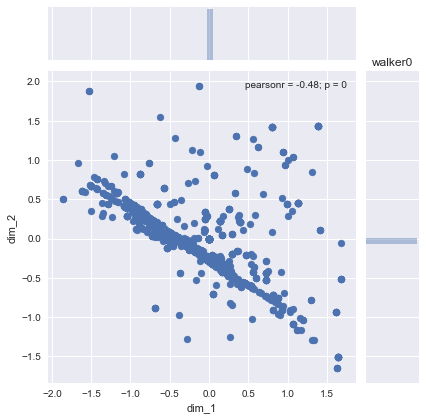

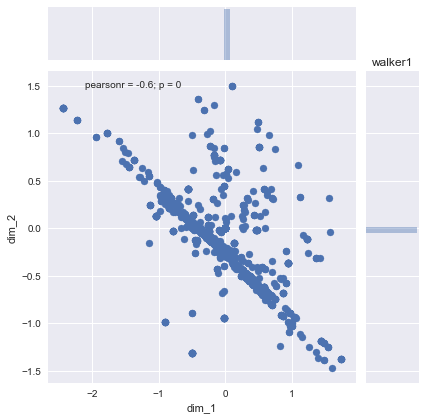

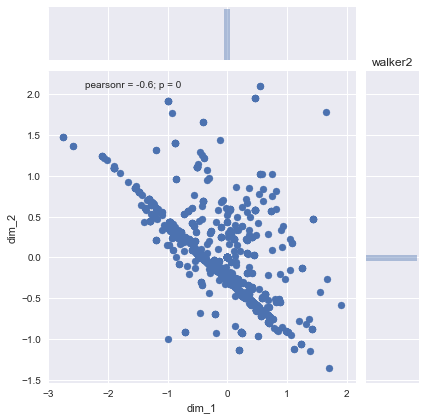

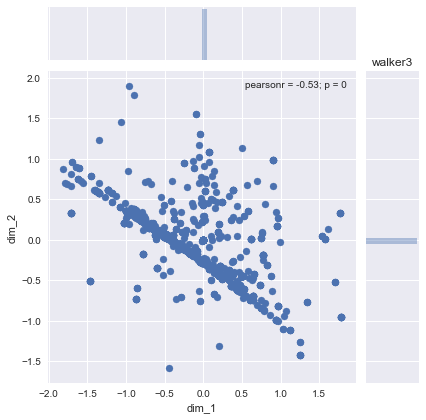

In [61]:
chain = sampler.history.get('chain')
x, y = ['dim_1', 'dim_2']
for i in range(nwalkers):
    df = DataFrame(np.vstack([chain[i, :, 0], chain[i, :, 1]]).T, columns=[x, y])
    sns.jointplot(x=x, y=y, data=df)
    sns.plt.title('walker%s' % i)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


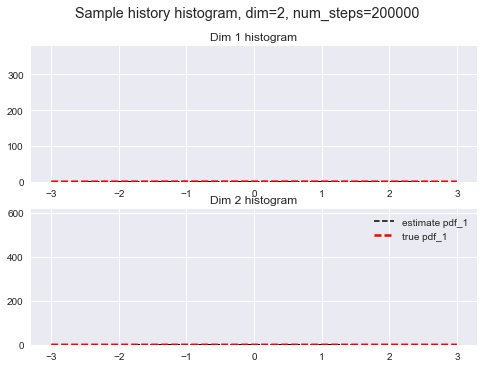

In [7]:
import math
def pdf(x):
    return np.exp(-x**2 / 2.0) / np.sqrt(2*math.pi)

chain = sampler.history.get_flat('chain', get_every=100)

n = 2
num_steps = len(chain)
num_bins = int(num_steps * 0.01)

fig, axs = plt.subplots(2, 1)
fig.suptitle("Sample history histogram, dim=%s, num_steps=%s" % (dim, num_steps))
for i in range(dim):
    idx = i if n == 1 or n == 2 else (i // 2, i % 2)
    _, bins, _ = axs[idx].hist(chain[:, i], num_bins, normed=1)
    
    y = pylab.normpdf(bins, 0, 1)
    l = axs[idx].plot(bins, y, 'k--', lw=1.5, label='estimate pdf_%s' % i)
    
    x = np.linspace(-3, 3, num_bins)
    p = axs[idx].plot(x, pdf(x), 'r--', lw=2.5, label='true pdf_%s' % i)
    pylab.legend()
    axs[idx].plot()
    axs[idx].set_title("Dim %s histogram" % int(i+1))

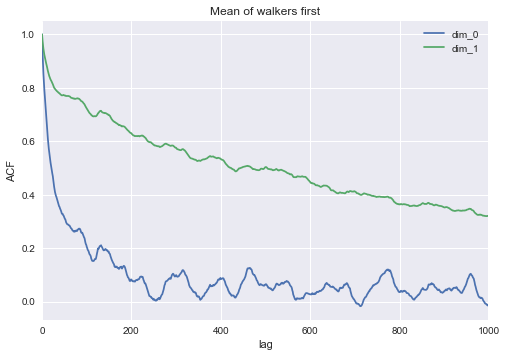

In [8]:
chain = sampler.history.get('chain')
plot_acf(chain, mean_first=True, max_lag=1000)

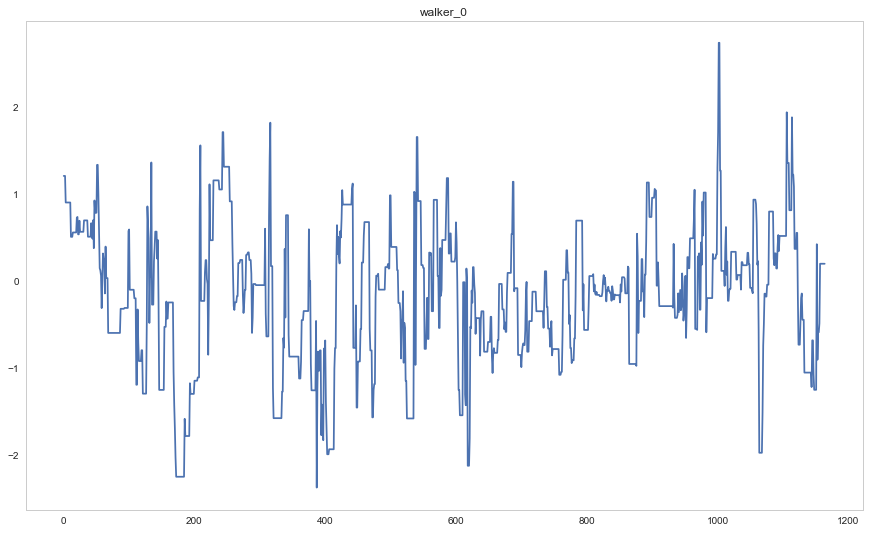

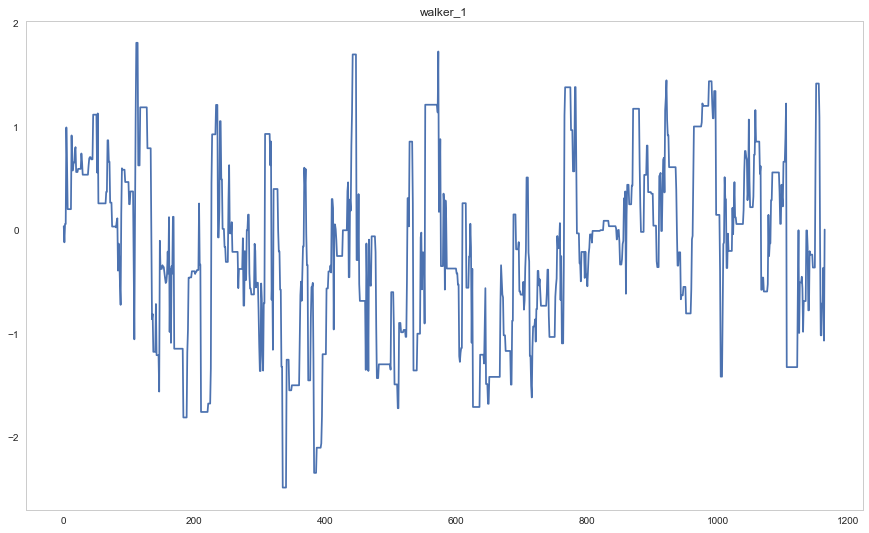

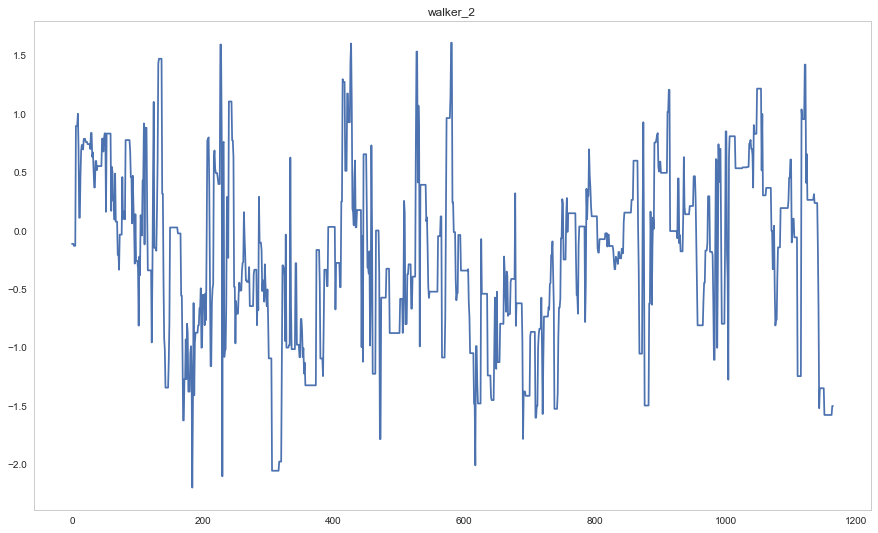

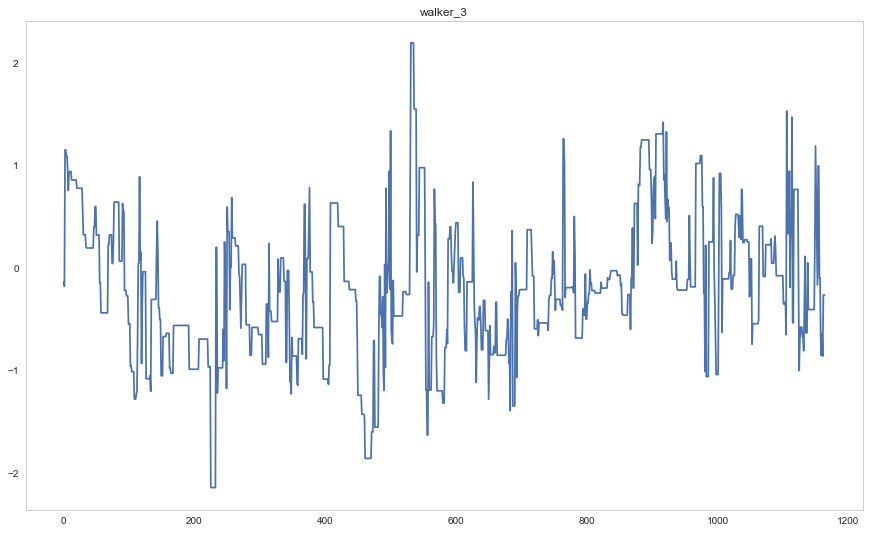

In [9]:
chain = sampler.history.get('chain')
for i in range(nwalkers):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(np.arange(1165), chain[i, :1165, 0])
    plt.title('walker_%s' % i)
plt.show()

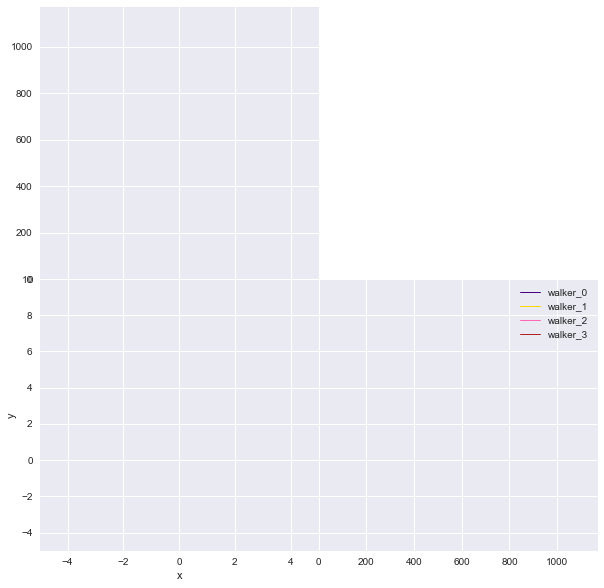

In [65]:
from matplotlib.animation import FuncAnimation

visualizer = Visualizer(sampler.history, False, max_len=1170, print_every=200)
animation = FuncAnimation(fig=visualizer.fig, func=visualizer, init_func=visualizer.init,
                        frames=np.arange(700), interval=50, blit=True, repeat=False)

In [66]:
from IPython.display import HTML
HTML(animation.to_html5_video())

200
400
600
800
1000


In [67]:
animation.save('download.mp4')

200
400
600
800
1000


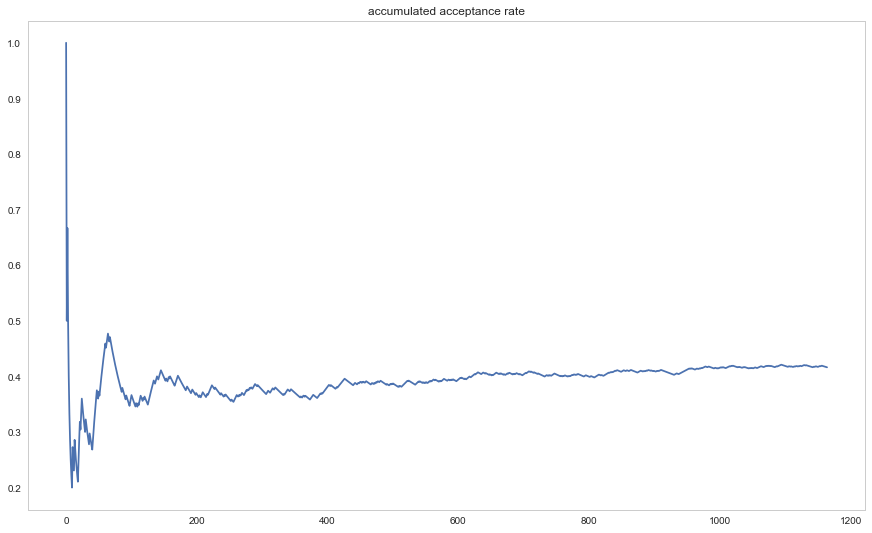

In [13]:
cum_acceptance_prob = np.cumsum(sampler.accepted[0])[1:] / np.arange(len(sampler.accepted[0]))[1:]
fig = plt.figure(figsize=(15, 9))
plt.plot(np.arange(1165), cum_acceptance_prob[:1165])
plt.title('accumulated acceptance rate')

# Exp 2.

In [22]:
proposal = PCNWalkMove(beta=0.1)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
try:
    sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True, store_every=50000, title='test')
except LinAlgError, err:
    print err
    
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

start location:  [[-0.53130271 -1.1348885 ]
 [-0.35365419  0.69938772]
 [-0.68678854  0.26996317]
 [ 0.62471548 -0.29413678]]
4309 2
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
4309 3
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
4310 0
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
4310 1
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
4310 2
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
Singular matrix
finishes in about 4.35 seconds
The chain is too short to reliably estimate the autocorrelation time


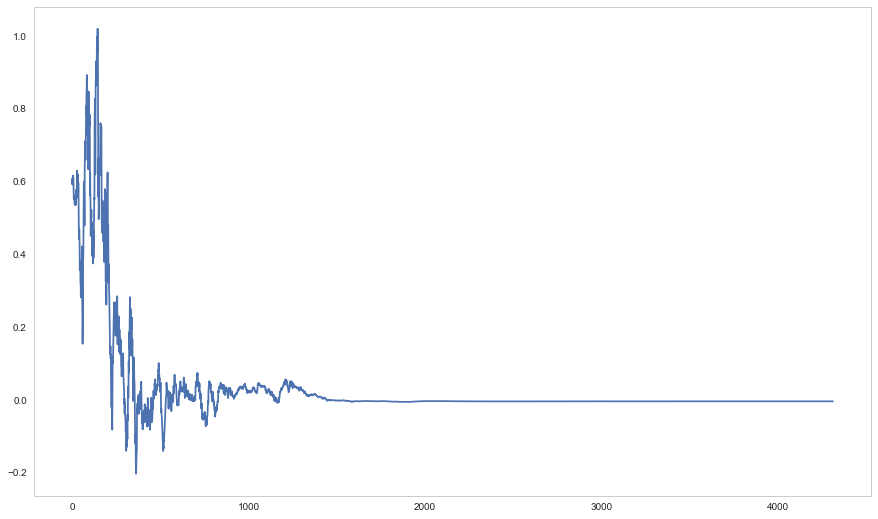

In [31]:
chain = sampler.history.get('chain')

fig = plt.figure(figsize=(15, 9))
plt.plot(np.arange(4310), chain[3, :4310, 0])
plt.show()

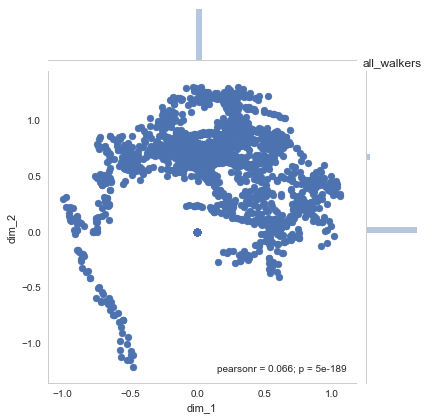

In [27]:
chain = sampler.history.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[:, 0], chain[:, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df)
sns.plt.title('all_walkers')

200
400
600
800
1000
1200
1400
1600
1800


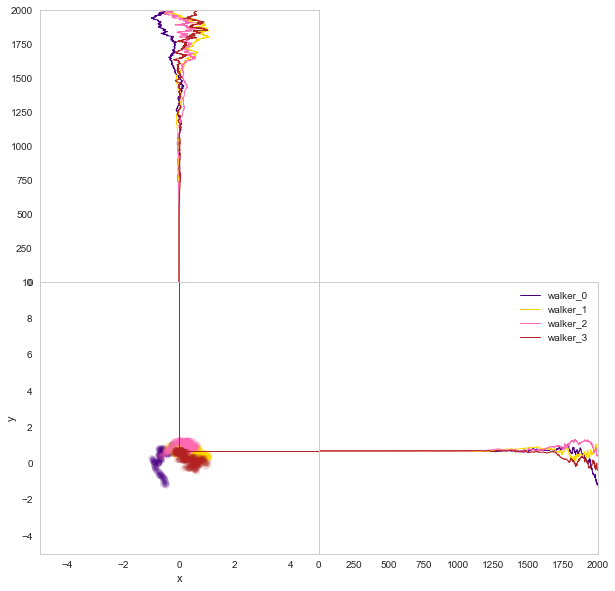

In [33]:
from matplotlib.animation import FuncAnimation

visualizer = Visualizer(sampler.history, False, max_len=2000, print_every=200)
animation = FuncAnimation(fig=visualizer.fig, func=visualizer, init_func=visualizer.init,
                        frames=np.arange(2000), interval=50, blit=True, repeat=False)
animation.save('beta_0.1.mp4')

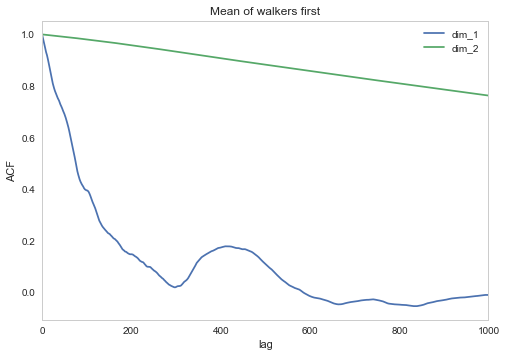

In [28]:
chain = sampler.history.get('chain')
plot_acf(chain, mean_first=True, max_lag=1000)

# Exp 3.

In [40]:
proposal = PCNWalkMove(beta=0.3)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
try:
    sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True, store_every=50000, title='test')
except LinAlgError, err:
    print err
    
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

start location:  [[-0.9967368  -0.01545307]
 [ 0.74204614  0.45640958]
 [-0.14305622  0.4739932 ]
 [-0.84876127  1.63996064]]
925 3
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
1163 0
('error found:', RuntimeWarning('covariance is not positive-semidefinite.',))
Singular matrix
finishes in about 2.29 seconds
The chain is too short to reliably estimate the autocorrelation time


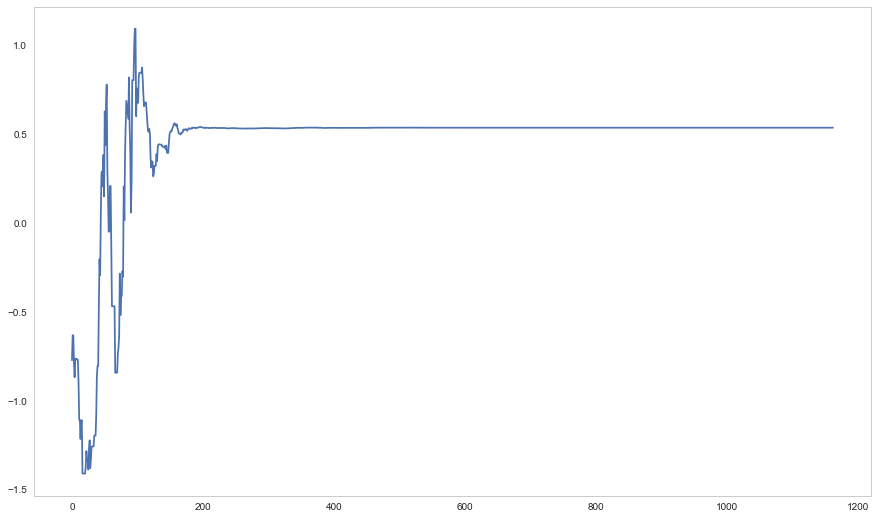

In [42]:
chain = sampler.history.get('chain')

fig = plt.figure(figsize=(15, 9))
plt.plot(np.arange(1163), chain[3, :1163, 0])
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 9))
plt.plot(np.arange(niters), chain[0, :, 0])
plt.show()